In [1]:
from trawl_sinn import  *

In [3]:
lambda_ = 0.5
def exp_integrated_trawl(s: torch.Tensor) -> torch.Tensor:
    """Exponential integrated trawl function G(s) = exp(-λ s) / λ."""
    return torch.exp(-lambda_ * s) / lambda_
  
gauss = GaussianTrawlProcess(
    integrated_trawl_function=exp_integrated_trawl,
    mean=0.0,          # marginal mean = 0
    var=1.0,           # marginal variance = 1
    theta_batch_first=True,
    arg_check=True,
)

# Observation grid (you can pick any increasing vector you like)
times = torch.linspace(0.0, 10.0, steps=201)      # 201 points, Δt ≈ 0.05
process_fdd = gauss.at_times(times)

In [14]:
data = process_fdd.sample(batch_size = 5000s)

loss_density = DensityLoss.from_fdd(
  gauss,
  lower = -2.0,
  upper = +2.0,
  n = 1000
)

loss_cf = CFRollingWindowLoss.from_empirical(
  data
)

loss_combined = loss_density + loss_cf

In [15]:
loss_cf(data)

tensor(0.0029)

In [6]:
gauss.theta_batch_first_default

True

200.0
(1500, 400)
(400, 400) (400, 400)
CPU times: user 482 ms, sys: 10.2 ms, total: 492 ms
Wall time: 498 ms


<timed exec>:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


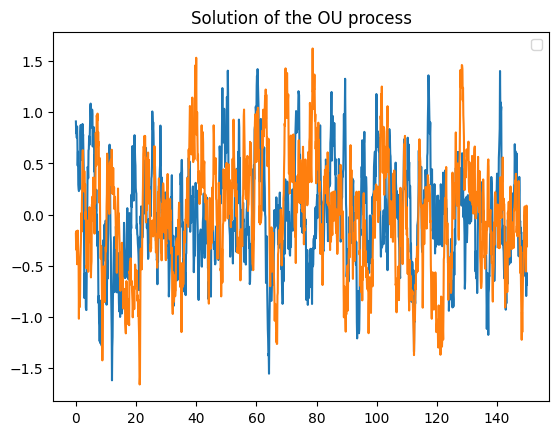

In [6]:
%%time
#### Generating SINN training data by solving SDE

import numpy as np
import matplotlib.pyplot as plt


#### Parameters
sigma = 0.5
gamma = 1  # coupling constant
beta = 1  # Inverse temperature, i.e. T=1/beta
dt = 0.01  # Step-size of the SDE solver
delta_t = 0.1  # Step-size of the temporally coarse-grained path
batch = 400  # Batch size
sec_length = 400  # Length of the input sequence


#### SDE solver (EM scheme)
Time = 5 * delta_t * sec_length
print(Time)
length = int(Time / dt) + 1
t = np.linspace(0, Time, length)
gap = int(delta_t / dt)
t_store = t[0:-1:gap]
q_store = np.zeros([t_store.size + 1, batch])
q = np.zeros((2, batch))
# solve SDE
j = 1
for i in range(1, length):
    q[1, :] = (
        q[0, :]
        - gamma * q[0, :] * dt
        + np.random.randn(1, batch) * np.sqrt(2 * dt * sigma**2)
    )
    if i % gap == 0:
        q_store[j, :] = q[1, :]
        j = j + 1
    q[0, :] = q[1, :]
Toss = int(t_store.size / 4)
q_store = q_store[Toss:-1, :]
print(q_store.shape)


plt.figure(1)
for i in range(2):
    plt.plot(t_store[Toss:] - t_store[Toss], q_store[:, i])
plt.legend()
plt.title("Solution of the OU process")


#### Constructing the sample traj for SINN learning
ini = np.random.randn(sec_length, batch)
Traj = q_store[0:sec_length, :]
T = np.arange(len(Traj[:, 1])) * delta_t
x = np.linspace(-5, 5, sec_length)
pdf_exact = np.exp(-(x**2) / (2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2)
print(ini.shape, Traj.shape)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F

In [10]:
# Input of SINN should be of the form (seq_len, batch, input_size)
device = 'cpu'
ini = np.random.randn(2 * sec_length, batch).astype(np.float32)
input = torch.from_numpy(ini.reshape(2 * sec_length, batch, 1)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2 * sec_length, batch_validation, 1), device=device)

Traj = Traj.astype(np.float32)
target = torch.from_numpy(Traj.reshape(sec_length, batch, 1)).to(device)
print("The torch input size is", input.size(), input.dtype)
print("The torch validation size is", val_set.size(), val_set.dtype)
print("The torch target size is", target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 1]) torch.float32
The torch validation size is torch.Size([800, 400, 1]) torch.float32
The torch target size is torch.Size([400, 400, 1]) torch.float32


In [17]:
N = 400
LAGS = 200
loss_pdf_empirical = DensityLoss.from_empirical(target, lower=-5, upper=5, n=N)

In [18]:
net = SINN(1, 2, 1, 1).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [21]:
# Training SINN
T_error = []
V_error = []
Step = []
for step in range(100):
    optimizer.zero_grad()
    ini = np.random.randn(2 * sec_length, batch).astype(np.float32)
    input = torch.from_numpy(ini.reshape(2 * sec_length, batch, 1)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:, :, :]
    loss = loss_pdf_empirical(prediction)
    loss.backward()
    optimizer.step()
    if step % 50 == 0:
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:, :, :]
            loss_val = loss_pdf_empirical(prediction)
            print("[%d]-th step loss: %.3f, %.3f" % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss <= 0.0005 and loss_val <= 0.0005:
        break
print("Training finished")


[0]-th step loss: 0.032, 0.032
[50]-th step loss: 0.016, 0.016
Training finished
